# Assignment 5

Task 1: Use PCA from previous assignment to convert data from 4D to 2D. If you did not manage to implement PCA, you can simply use first 2 dimensions of the database. (4 points if PCA is used, otherwise 1 point)

Task 2a: Implement kNN classification algorithm and apply it to classify iris database. (2 points)

Task 2b: Try different values of k = {1, 2, 3, 4, 5} and print prediction accuracy for validation set. Please select optimal value of k and justify your selection. (3 points)

Task 3: Implement random forest classification and apply it to classify iris database. Use any reasonable parameters you want. (3 points)

Taks 4: Visualize results of kNN and random forests (4 points)

In [8]:
# Load packages as usual
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
import matplotlib.cm as cm
import numpy.matlib
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


# Manipulating figure sizes
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15,7)
matplotlib.rc('font', size=15)
matplotlib.rc('axes', titlesize=15)

### Database

We have a database of iris flowers, where each datapoint is defined with 4 features: a) sepal length in cm, b) sepal width in cm, c) petal length in cm, d) petal width in cm. Each datapoint has also a label from the set: Iris Setosa (label = 0), Iris Versicolour (label = 1), Iris Virginica (label = 2).

### Reading data

In [14]:
def __read(fileName, pTrainSamples = 0.6, pValidSamples = 0.2):
    emp_df = pd.read_csv(fileName)
    values = emp_df.values
    values = emp_df.values.astype(np.float)
    
    nTrainSamples = int(values.shape[0] * pTrainSamples)
    nValidSamples = int(values.shape[0] * pValidSamples)
    
    trainingFeatures = values[0:nTrainSamples, 0:-1]
    trainingLabels   = values[0:nTrainSamples, -1]
    validationFeatures = values[nTrainSamples:nTrainSamples + nValidSamples, 0:-1]
    validationLabels   = values[nTrainSamples:nTrainSamples + nValidSamples, -1]
    testingFeatures    = values[nTrainSamples + nValidSamples:, 0:-1]
    testingLabels      = values[nTrainSamples + nValidSamples:, -1]
    return trainingFeatures.astype(np.float), trainingLabels.astype(np.int), \
           validationFeatures.astype(np.float), validationLabels.astype(np.int), \
           testingFeatures.astype(np.float), testingLabels.astype(np.int)


trainingFeatures, trainingLabels, validationFeatures, validationLabels, testingFeatures, testingLabels = __read('iris_new.csv')
#print(trainingFeatures)
N , d = trainingFeatures.shape
print('shape training = ', trainingFeatures.shape)
print('Dimension:', d)
print('Sample size:', N)
print('shape validation = ', validationFeatures.shape)
print('shape testing = ', testingFeatures.shape)

shape training =  (88, 4)
Dimension: 4
Sample size: 88
shape validation =  (29, 4)
shape testing =  (31, 4)


### Converting data to two dimensions using PCA

The conversion to 2D from 4D input is needed to simplify visualization of the results. Please generate PCA on the training, and then convert training and testing data from 4D to 2D. 

In [24]:
def __PCA(data):
    data = data.T #the data is transposed
    #Find the center of the data, more in depth methods could be explored here
    data_cent = data - np.mean(data, axis = 1).reshape((-1,1)) #substracting mean shape
    # take covariance
    covM = np.cov(data_cent)
    
    PCevals, PCevecs = np.linalg.eigh(covM)
    #the greater the eigenvalues the greater the importance to the feature space,
    #they represent the magnitude of the eigenvector in the space
    #if a vector has a magnitude of 0 it means that it has no variance in the feature space
    #if it has no variance it does not matter what the weight of the feature is as it will have no impact
    PCevals = PCevals[::-1] # get them in decreasing order, so that the most impactful one is first in the arr
    #eigenvectors determine the direction in which the variance is in the space
    PCevecs = np.flip(PCevecs,1)#flip them so they match their eigenvalues
    return PCevals, PCevecs


PCevals, PCevecs = __PCA(trainingFeatures)

to cover  90.0 % of the results, the first  1 / 4 components are needed
to cover  95.0 % of the results, the first  2 / 4 components are needed
to cover  99.0 % of the results, the first  3 / 4 components are needed
to cover  99.9 % of the results, the first  4 / 4 components are needed


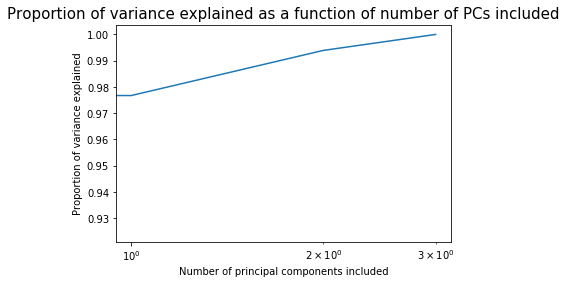

In [25]:
import math

variance_explained_per_component = PCevals/np.sum(PCevals)
#https://numpy.org/doc/stable/reference/generated/numpy.cumsum.html
cumulative_variance_explained = np.cumsum(variance_explained_per_component)

# Let's print out the proportion of variance explained
#d is the dimension
percentageCovered = []
coverageArr = ([0.90, 0.95, 0.99, 0.999, 1.0])

lengthArr = len(coverageArr)
indexCoverageArr = 0
for i in range(d):
    val = cumulative_variance_explained[i]
    #print('Proportion of variance explained by the first '+str(i+1)+' principal components:', val, '\n')
    if indexCoverageArr < lengthArr and coverageArr[indexCoverageArr] < val :
        percentageCovered.append(i+1)
        indexCoverageArr += 1

for i in range(len(percentageCovered)):
     print("to cover ",coverageArr[i]*100,
           "% of the results, the first ", percentageCovered[i],"/",d,"components are needed")
        
plt.xscale("log")
plt.plot(cumulative_variance_explained)
plt.xlabel('Number of principal components included')
plt.ylabel('Proportion of variance explained')
plt.title('Proportion of variance explained as a function of number of PCs included')
plt.savefig('variancePC.png')

In [26]:
###transforming data to another dimension, emitting some features

In [27]:
def __transformData(features, PCevecs):
    return np.dot(features,  PCevecs[:, 0:2])


print('eigenvals\n', PCevals,"\neigenvectors\n", PCevecs)
trainingFeatures2D = __transformData(trainingFeatures, PCevecs)
validationFeatures2D = __transformData(validationFeatures, PCevecs)
testingFeatures2D = __transformData(testingFeatures, PCevecs)
print('shape training = ', trainingFeatures2D.shape)
print('shape validation = ', validationFeatures2D.shape)
print('shape testing = ', testingFeatures2D.shape)

eigenvals
 [4.32703141 0.24338235 0.08039409 0.0284689 ] 
eigenvectors
 [[-0.3874248   0.71754466  0.40859557 -0.40997726]
 [ 0.08137676  0.65064637 -0.57767387  0.48613787]
 [-0.84698964 -0.20996487  0.05278926  0.48552713]
 [-0.35480755 -0.13305534 -0.70466719 -0.59987668]]
shape training =  (88, 2)
shape validation =  (29, 2)
shape testing =  (31, 2)


### Visualizing 2D data

This is visualization of the training data with labels.

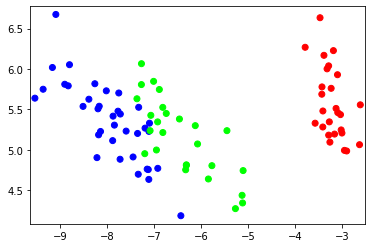

In [28]:
def __visualizeLabels(features, referenceLabels):
    plt.figure()
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold  = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    y = referenceLabels

    plt.scatter(features[:, 0], features[:, 1], c = y, cmap = cmap_bold)
    plt.xlim(features[:, 0].min() - 0.1, features[:, 0].max() + 0.1)
    plt.ylim(features[:, 1].min() - 0.1, features[:, 1].max() + 0.1)
    plt.show()
    t = 0
    
__visualizeLabels(trainingFeatures2D, trainingLabels)

### k-NN implementation

Implement k-NN for prediction of iris labels. Test k-NN for different k-s and find the best one in the space of {1, 2, 3, 4, 5}. Use validation set for testing different k values.

Please note that it is NOT allowed to use KNeighborsClassifier or other existing implementation of k-NN. We expect that can implement it yourself.


In [29]:
def __kNN(trainingFeatures2D, trainingLabels, n_neighbors):
    predictor = KNeighborsClassifier(n_neighbors=n_neighbors)
    predictor.fit(trainingFeatures2D, trainingLabels)
    return predictor
def __kNNTest(trainingFeatures2D, trainingLabels, n_neighbors, validationFeatures2D, validationLabels):
    # calculate the Euclidean distance between two vectors
    var = 0.4
    temp = 0
    for i in range(len(validationFeatures2D)):
        distance = []
        for j in trainingFeatures2D:
                   distance.append(np.linalg.norm(validationFeatures2D[i]-j))
        distance = np.array(distance)
        idx = np.argpartition(distance,n_neighbors)
        lbl = trainingLabels[idx[:n_neighbors]]
        prd = np.mean(lbl) - validationLabels[i]
        if prd <= var and prd >= -var:
                temp += 1
    accuracy = temp/len(validationLabels)
    return accuracy

for n in range(1, 6):
    print('accuracy for,',n, ', nearest neighbor(s) = ', __kNNTest(trainingFeatures2D, trainingLabels, n, validationFeatures2D, validationLabels))

accuracy for, 1 , nearest neighbor(s) =  0.9310344827586207
accuracy for, 2 , nearest neighbor(s) =  0.9310344827586207
accuracy for, 3 , nearest neighbor(s) =  1.0
accuracy for, 4 , nearest neighbor(s) =  1.0
accuracy for, 5 , nearest neighbor(s) =  1.0


### Random forests implementation

Implement random forest for prediciton of iris labels. Select any reasonable configuration of parameters for the random forest predictor

Here you are allowed to use existing implementations, please check RandomForestClassifier from sklearn

In [30]:
def __randomForests(trainingFeatures2D, trainingLabels):
    predictor = RandomForestClassifier(n_estimators=10,n_jobs=2,random_state=0)
    predictor.fit(trainingFeatures2D, trainingLabels)
    return predictor

### Visualizing predictor boundaries

Modify function __visualizeLabels to visualize not only labels but also decision boundaries of a predictor. Apply kNN classifier with optimal k on testing features and visualize the obtained results. Visualize the obtained results in comparion with the true testing labels. Apply random forest classifier on testing features and visualize the obtained results.

Here, you are allowed to use KNeighborsClassifier in __kNN.

Hint: check this example https://stackoverflow.com/questions/41138706/recreating-decision-boundary-plot-in-python-with-scikit-learn-and-matplotlib

<Figure size 432x288 with 0 Axes>

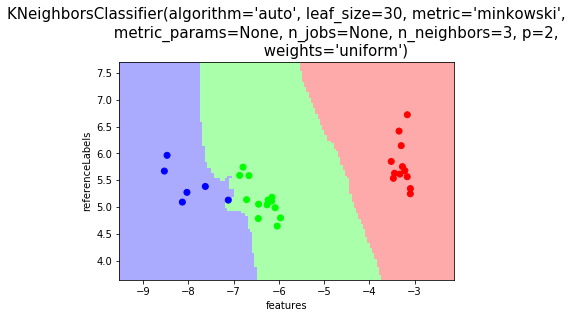

<Figure size 432x288 with 0 Axes>

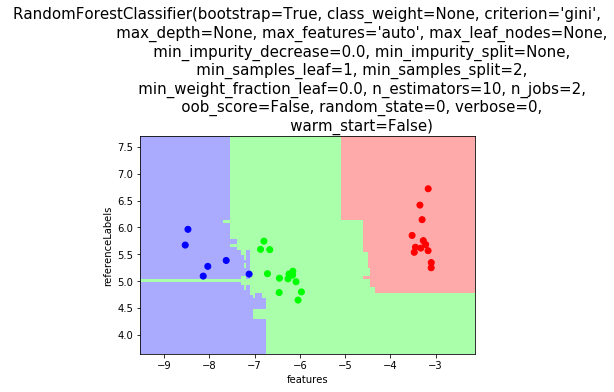

In [31]:
def __visualizePredictions(predictor, features, referenceLabels):
    plt.figure()
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold  = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    h = 0.05
    for weights in ['uniform', 'distance']:
        # we create an instance of the Predictor Classifier.
        clf = predictor

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        x_min, x_max = features[:, 0].min() - 1, features[:, 0].max() + 1
        y_min, y_max = features[:, 1].min() - 1, features[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    #get xx and yy as coordinates for visualization, and Z as labels for area visualization
    plt.pcolormesh(xx, yy, Z, cmap = cmap_light)
    # Plot also the training points
    plt.scatter(features[:, 0], features[:, 1], c = referenceLabels, cmap = cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(str(predictor))
    plt.xlabel("features")
    plt.ylabel("referenceLabels")
    plt.show()


k = 3 #using the 3 nearest, as that was the optimal from ex c
kNNPredictor = __kNN(trainingFeatures2D, trainingLabels, k)
RFPredictor  = __randomForests(trainingFeatures2D, trainingLabels)
__visualizePredictions(kNNPredictor, testingFeatures2D, testingLabels)
__visualizePredictions(RFPredictor, testingFeatures2D, testingLabels)